In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV

In [2]:
df4 = pd.read_csv("../data/pre-processed_data/df4.csv")
df4

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,Weekday
0,2019-01-01 00:01:11,1,89,0,3,0,2,3,1.0,1,1,1,0,5
1,2019-01-01 00:01:17,1,89,1,3,0,2,3,1.0,2,1,1,0,5
2,2019-01-01 00:02:49,1,238,0,3,1,0,3,1.0,1,1,1,0,5
3,2019-01-01 00:03:13,1,238,1,3,1,0,3,1.0,2,1,1,0,5
4,2019-01-01 00:04:33,0,124,0,2,0,0,1,0.5,1,1,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50324,2019-02-28 23:45:39,2,415,0,3,0,2,3,1.0,1,2,28,23,4
50325,2019-02-28 23:46:48,0,91,0,3,0,1,3,1.0,1,2,28,23,4
50326,2019-02-28 23:47:04,0,91,0,3,0,1,3,1.0,2,2,28,23,4
50327,2019-02-28 23:47:36,0,91,0,3,0,1,3,1.0,3,2,28,23,4


In [3]:
features = df4.drop(["tmsp","success",'Month'],axis=1)
target = df4['success']

In [4]:
from imblearn.over_sampling import RandomOverSampler

# RANDOM OVER SAMPLER to handle class imbalance
ros = RandomOverSampler(sampling_strategy="not majority", random_state=7)
X_res, y_res = ros.fit_resample(features, target)

In [5]:
from sklearn.model_selection import train_test_split
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [6]:
# EVALUATING METRICS AND PLOTTING 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report 

def metrics_and_plots(model, y_test, y_pred):
     # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.2f}")

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.2f}\n")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n",conf_matrix,"\n")
    
    #Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Predict probabilities for positive class (success) for the test set
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, probs)
    print(f"\nAUC Score: {auc:.2f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random Guess Line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Create Calibration Plot
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.figure(figsize=(6, 4))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Plot')
    plt.plot([0, 1], [0, 1], 'k--')  # Perfectly Calibrated Line
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.show()

 **Random Forest - Hyperparameter Tuning with GridSearch CV**

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 9, num = 5)]

rf_grid = {'n_estimators':n_estimators,
              'criterion':criterion,
              'max_depth':max_depth}

rf = RandomForestClassifier(random_state=7)

rf_cv = GridSearchCV(rf,rf_grid,cv=3, verbose=2)

rf_cv.fit(X_res, y_res)

print(rf_cv.best_score_, rf_cv.best_params_)

# Predict on the test set with the best model
best_model = rf_cv.best_estimator_
rf_best_predictions = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_best_predictions)
classification_report_result = classification_report(y_test, rf_best_predictions)
confusion_matrix_result = confusion_matrix(y_test, rf_best_predictions)

print("Random Forest Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END .......criterion=gini, max_depth=1, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=1, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=1, n_estimators=10; total time=   0.1s
[CV] END ......criterion=gini, max_depth=1, n_estimators=257; total time=   4.5s
[CV] END ......criterion=gini, max_depth=1, n_estimators=257; total time=   4.7s
[CV] END ......criterion=gini, max_depth=1, n_estimators=257; total time=   4.6s
[CV] END ......criterion=gini, max_depth=1, n_estimators=505; total time=   8.2s
[CV] END ......criterion=gini, max_depth=1, n_estimators=505; total time=   8.4s
[CV] END ......criterion=gini, max_depth=1, n_estimators=505; total time=   8.5s
[CV] END ......criterion=gini, max_depth=1, n_estimators=752; total time=  12.0s
[CV] END ......criterion=gini, max_depth=1, n_estimators=752; total time=  13.1s
[CV] END ......criterion=gini, max_depth=1, n_e

[CV] END ...criterion=entropy, max_depth=3, n_estimators=752; total time=  19.9s
[CV] END ..criterion=entropy, max_depth=3, n_estimators=1000; total time=  26.0s
[CV] END ..criterion=entropy, max_depth=3, n_estimators=1000; total time=  27.2s
[CV] END ..criterion=entropy, max_depth=3, n_estimators=1000; total time=  27.2s
[CV] END ....criterion=entropy, max_depth=5, n_estimators=10; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=5, n_estimators=10; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=5, n_estimators=10; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=257; total time=   9.3s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=257; total time=   9.1s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=257; total time=   9.1s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=505; total time=  17.4s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=505; total time=  17.8s
[CV] END ...criterion=entrop

TypeError: metrics_and_plots() takes 1 positional argument but 3 were given

Accuracy: 0.67
Precision: 0.65
Recall: 0.74
F1 Score: 0.69

Confusion Matrix:
 [[4830 3138]
 [2132 5941]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65      7968
           1       0.65      0.74      0.69      8073

    accuracy                           0.67     16041
   macro avg       0.67      0.67      0.67     16041
weighted avg       0.67      0.67      0.67     16041


AUC Score: 0.74


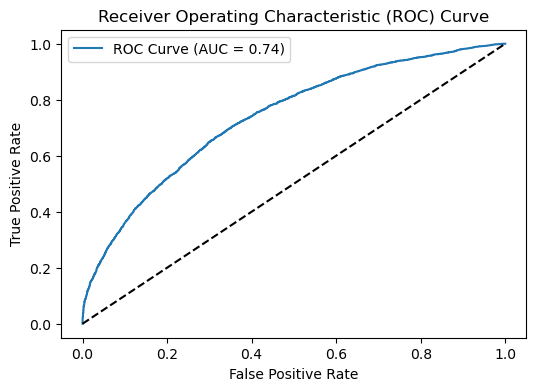

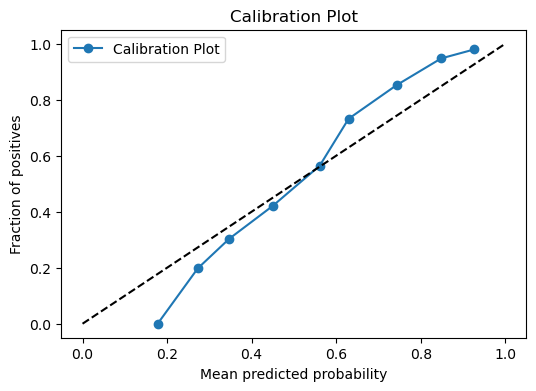

In [13]:
metrics_and_plots(best_model,y_test,rf_best_predictions)

**Gradient Boosting Classifier with RandomizedSearch CV**

Best Parameters: {'learning_rate': 0.11495493205167782, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 157}
Accuracy: 0.68
Precision: 0.66
Recall: 0.73
F1 Score: 0.69

Confusion Matrix:
 [[4946 3022]
 [2168 5905]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.62      0.66      7968
           1       0.66      0.73      0.69      8073

    accuracy                           0.68     16041
   macro avg       0.68      0.68      0.68     16041
weighted avg       0.68      0.68      0.68     16041


AUC Score: 0.73


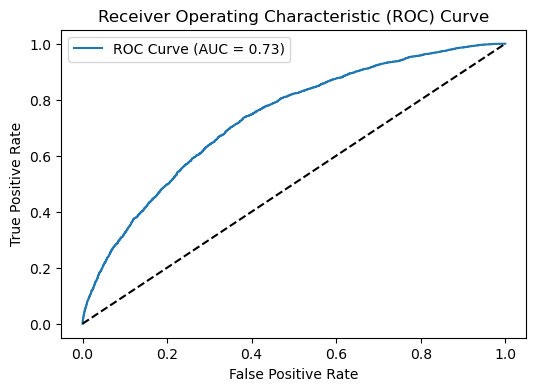

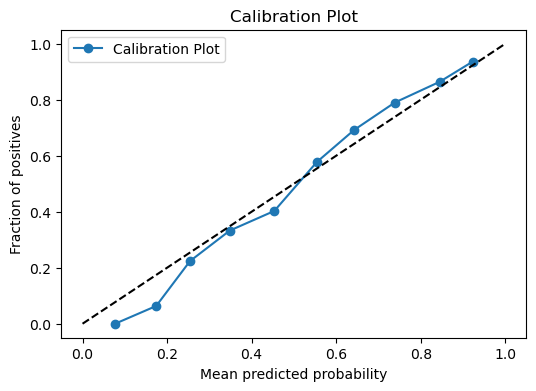

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


# Create GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier()

# Define the parameter distributions to sample from
gb_param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 6),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Create RandomizedSearchCV
gb_cv = RandomizedSearchCV(gb_classifier, param_distributions=gb_param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
gb_cv.fit(X_train, y_train)

# Get the best parameters
best_params = gb_cv.best_params_
print("Best Parameters:", best_params)

# Predict using the best model
gb_best_predictions = gb_cv.predict(X_test)

metrics_and_plots(gb_cv,y_test,gb_best_predictions)

**SVC - GridSearchCV**

In [ ]:
from sklearn.svm import SVC 

model = SVC() 

# defining parameter range 
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf']}  
  
# svc_cv = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3) 
svc_cv = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
svc_cv.fit(X_train, y_train) 
print(svc_cv.best_score_, svc_cv.best_params_)
# print best parameter after tuning 
print(svc_cv.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(svc_cv.best_estimator_) 

svc_best_predictions = svc_cv.predict(X_test) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time= 6.1min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time= 5.5min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time= 5.4min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time= 5.3min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time= 5.4min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.680 total time= 6.5min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.678 total time= 5.4min
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.684 total time= 5.3min
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.681 total time= 5.4min
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.666 total time= 5.5min
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.600 total time= 3.8min
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;,

In [19]:
metrics_and_plots(svc_cv, y_test, svc_best_predictions)

model  GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=3)
Accuracy: 0.97
Precision: 0.97
Recall: 0.96
F1 Score: 0.97

Confusion Matrix:
 [[7696  272]
 [ 289 7784]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      7968
           1       0.97      0.96      0.97      8073

    accuracy                           0.97     16041
   macro avg       0.97      0.97      0.97     16041
weighted avg       0.97      0.97      0.97     16041



AttributeError: predict_proba is not available when  probability=False

In [ ]:
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [ ]:
from xgboost import XGBClassifier

param_grid ={'max_depth': hp.quniform("max_depth", 3, 15, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 50,150,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }
xgb = XGBClassifier()
# Create RandomizedSearchCV
xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
xgb_cv.fit(X_train, y_train)

# Get the best parameters
best_params = xgb_cv.best_params_
print("Best Parameters:", best_params)

# Predict using the best model
xgb_best_predictions = xgb_cv.predict(X_test)



metrics_and_plots(xgb_cv,y_test,xgb_best_predictions)